##### Case 1:Semi classical Jaynes Cummings Model-Classical photon and Quantum atom
We solve for the position and momentum (and consequently the wave function) using the follwing equations-

The Interaction Hamiltonian $H_Q$ is
$$H_Q=\frac{\hbar \omega_a}{2}\sigma_z + \frac{\hbar g}{2}(a^\dagger\sigma_- + a\sigma_+)$$

The effective Hamiltonian of the system is
$$H = \hbar\omega_c \left(a^\dagger a + \frac{1}{2}\right) + \langle \Psi | H_Q | \Psi \rangle = \frac{p^2}{2m} + \frac{1}{2}m\omega_c^2 x^2 + \langle \Psi | H_Q | \Psi \rangle$$

We also have the following differential equations-
$$\frac{dp}{dt} = -\frac{\partial H}{\partial x} = m\omega_c^2x+\frac{\hbar g}{2}\sqrt{\frac{m\omega_c}{2\hbar}} \langle \psi|\sigma_+ + \sigma_-|\psi\rangle$$
$$ \frac{dx}{dt} = \frac{\partial H}{\partial p}=\frac{p}{m}+\frac{\hbar g\iota}{2m\omega_c}\sqrt{\frac{m\omega_c}{2\hbar}} \langle \psi|\sigma_+ - \sigma_-|\psi\rangle$$

So, we first define a spin state in a spin basis and thus define the raising and lowering operators. We also define other constants like $g$, $\hbar$, $\omega_a$ etc. and this allows us to find $H_Q$ for a particular position and momentum. Using $H_Q$ and $\psi$, we can find the effective Hamiltonian $H$ of the system, which on partial derivative with position and momentum can give us the next time step's momentum and position respectively, as governed by the PDEs. This allows us to iteratively find evolution of $x$, $p$ and $\psi$

In [133]:
using QuantumOptics
using Plots

spin=SpinBasis(1//2)

raising=sigmap(spin)
lowering=sigmam(spin)
sigz=sigmaz(spin)
wc = 0.1
wa = 0.1
g = 1.
ħ = 1.
m = 1.

function getHQ(position, momentum)
    a=sqrt(m*wc/(2*ħ))*(position+(im*momentum)/(m*wc))
    H_Q = ħ*wa*sigz/2 + ħ*g*(conj(a)*lowering + a*raising)/2     #Since a is a number in this case and not a operator, we can just take conjugate
    return H_Q
end

function run(;p_init, x_init, ψ_init, endTime, Δt)

    #defining initial state of the system
    ψ=[ψ_init,]
    x=[x_init,]
    p=[p_init,]

    currentx = x_init
    currentp = p_init
    currentψ = ψ_init

    T=[0:Δt:endTime;]
    for t in T[2:end]
        H_Q = getHQ(currentx, currentp)
        H = currentp^2/(2*m) + (m*wc^2*currentx^2)/2 + expect(H_Q, currentψ)

        dHdx=m*wc^2*currentx + ħ*g/2*sqrt(m*wc/(2*ħ))*expect(raising + lowering, currentψ)
        dHdp = currentp/m + ħ*g/2*sqrt(m*wc/(2*ħ))*(im/(m*wc))*expect(raising - lowering, currentψ)
        currentx = currentx + dHdp*Δt
        currentp = currentp - dHdx*Δt
        currentψ = timeevolution.schroedinger([0,Δt], currentψ, H_Q)[2][2]
        push!(x, currentx)
        push!(p, currentp)
        push!(ψ, currentψ)
        # print(currentx)
    end
    return T,x,p,ψ
end

run (generic function with 1 method)

In [134]:
p_init=0.5
x_init=1.0
ψ_init=spinup(spin)
Δt=0.01
endTime=150
T,x,p,ψ=run(p_init=p_init, x_init=x_init, ψ_init=ψ_init, endTime=endTime, Δt=Δt)
;

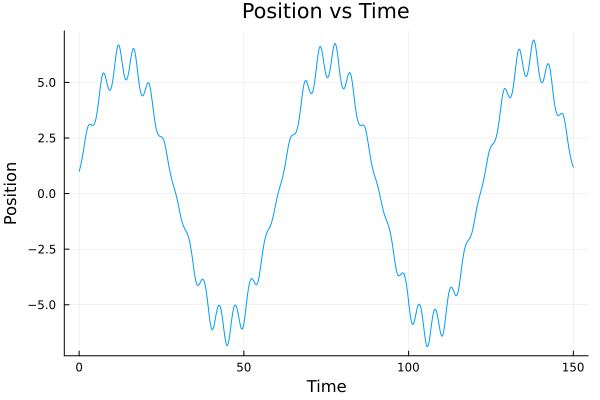

In [135]:
plot(T,x,xlabel="Time",ylabel="Position",title="Position vs Time",legend=false)

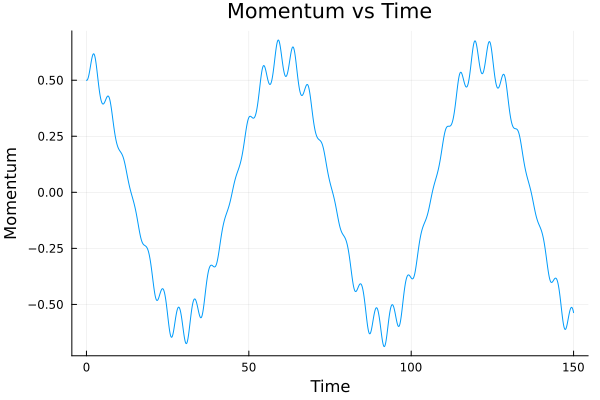

In [136]:
plot(T,p,xlabel="Time",ylabel="Momentum",title="Momentum vs Time",legend=false)

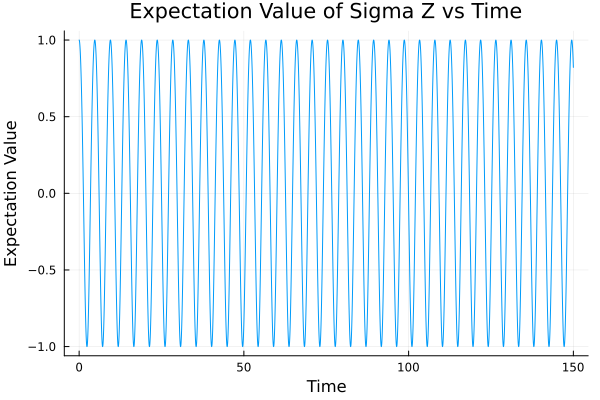

In [137]:
plot(T, real.(expect(sigz,ψ)), xlabel="Time", ylabel="Expectation Value", title="Expectation Value of Sigma Z vs Time", legend=false)

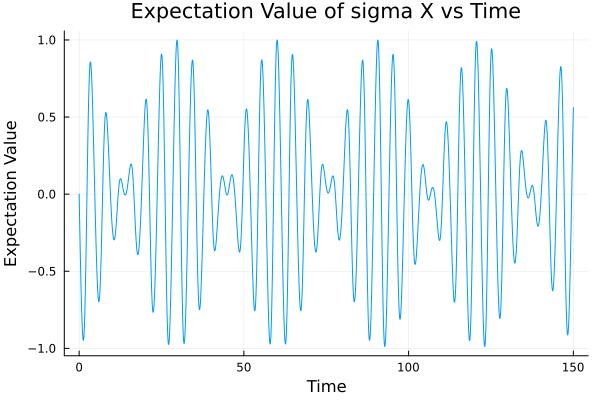

In [138]:
sigx=sigmax(spin)
plot(T, real.(expect(sigx,ψ)), xlabel="Time", ylabel="Expectation Value", title="Expectation Value of sigma X vs Time", legend=false)

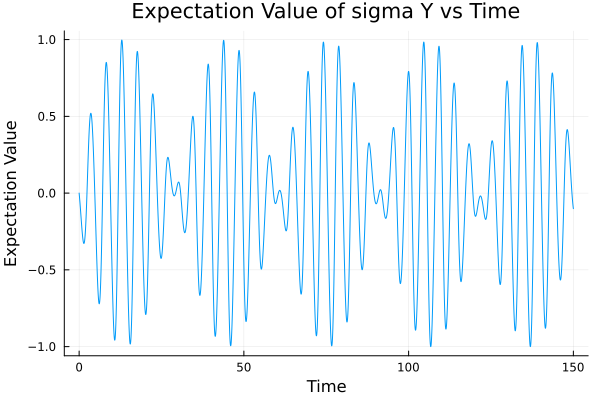

In [139]:
sigy=sigmay(spin)
plot(T, real.(expect(sigy,ψ)), xlabel="Time", ylabel="Expectation Value", title="Expectation Value of sigma Y vs Time", legend=false)

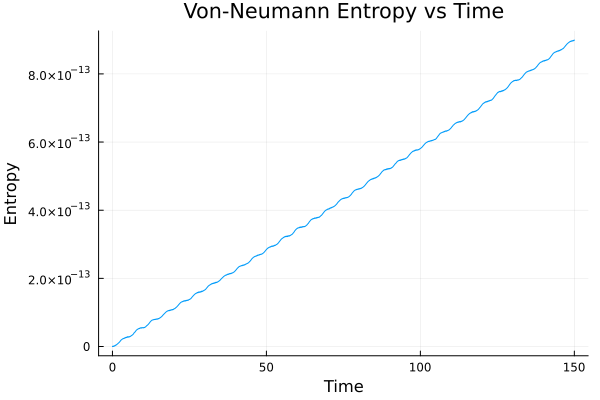

In [140]:
plot(T, real.(entropy_vn.(ψ)), xlabel="Time", ylabel="Entropy", title="Von-Neumann Entropy vs Time", legend=false)

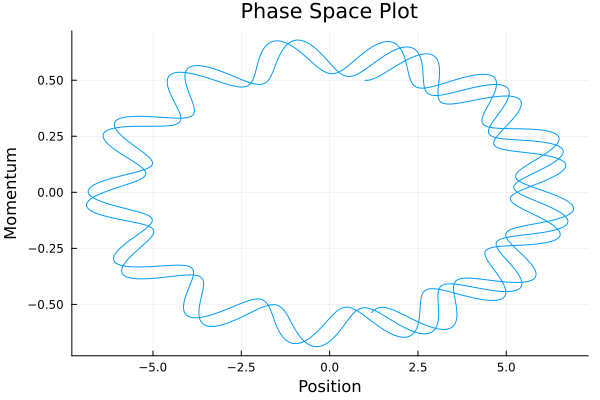

In [141]:
plot(x,p,xlabel="Position",ylabel="Momentum",title="Phase Space Plot",legend=false)

##### Now, lets solve for the fully quantum case when both the oscillator and the atom are quantized

In [144]:

# Parameters
N_cutoff = 10

ωc = 0.1
ωa = 0.1
g = 1.0
ħ = 1.0

# Bases for the spin states and the cavity modes
b_fock = FockBasis(N_cutoff)
b_spin = SpinBasis(1 // 2)
b = b_fock ⊗ b_spin

# Operators
a = destroy(b_fock)
a_dag = create(b_fock)
N = number(b_fock) # number operator for the cavity i.e, N = a†a

sig_m = sigmam(b_spin)
sig_p = sigmap(b_spin)
sig_z = sigmaz(b_spin)

# Hamiltonian
Hatom = ωa * sig_z / 2 * ħ
Hfield = ωc * (N + 1/2*one(b_fock)) * ħ
Hint = g * (a_dag ⊗ sig_m + a ⊗ sig_p) * ħ / 2
H = one(b_fock) ⊗ Hatom + Hfield ⊗ one(b_spin) + Hint

Operator(dim=22x22)
  basis: [Fock(cutoff=10) ⊗ Spin(1/2)]sparse([1, 13, 2, 14, 3, 15, 4, 16, 5, 17  …  6, 18, 7, 19, 8, 20, 9, 21, 10, 22], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5  …  18, 18, 19, 19, 20, 20, 21, 21, 22, 22], ComplexF64[0.1 + 0.0im, 0.5 + 0.0im, 0.2 + 0.0im, 0.7071067811865476 + 0.0im, 0.3 + 0.0im, 0.8660254037844386 + 0.0im, 0.4 + 0.0im, 1.0 + 0.0im, 0.5 + 0.0im, 1.118033988749895 + 0.0im  …  1.224744871391589 + 0.0im, 0.6 + 0.0im, 1.3228756555322954 + 0.0im, 0.7 + 0.0im, 1.4142135623730951 + 0.0im, 0.8 + 0.0im, 1.5 + 0.0im, 0.9 + 0.0im, 1.5811388300841898 + 0.0im, 1.0 + 0.0im], 22, 22)

In [143]:
# Initial state
α = 1.
Ψ0 = coherentstate(b_fock, α) ⊗ spindown(b_spin)
# coherentstate is a quantum state of the form exp(-|α|^2/2) * ∑_{n=0}^∞ α^n / sqrt(n!) |n> and 
# it's expectation values gives the classical EM field.

# Integration time
T = [0:0.1:100;]

# Schroedinger time evolution
tout, Ψt = timeevolution.schroedinger(T, Ψ0, H)

# expectation values
exp_N = real(expect(N ⊗ one(b_spin), Ψt))
exp_sig_z = real(expect(one(b_fock) ⊗ sig_z, Ψt))
exp_sig_x = real(expect(one(b_fock) ⊗ sigmax(b_spin), Ψt))
exp_sig_y = real(expect(one(b_fock) ⊗ sigmay(b_spin), Ψt));

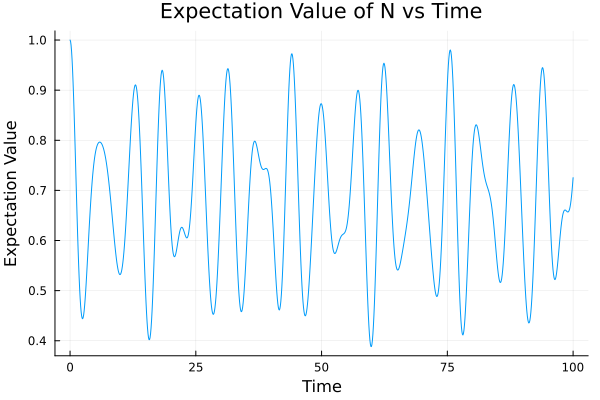

In [145]:
plot(T, exp_N, xlabel="Time", ylabel="Expectation Value", title="Expectation Value of N vs Time", legend=false)

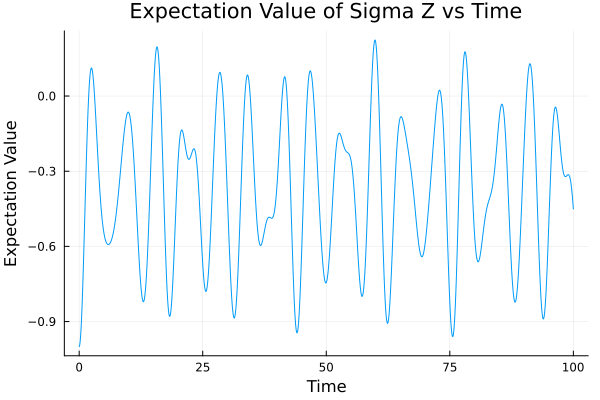

In [146]:
plot(T, exp_sig_z, xlabel="Time", ylabel="Expectation Value", title="Expectation Value of Sigma Z vs Time", legend=false)

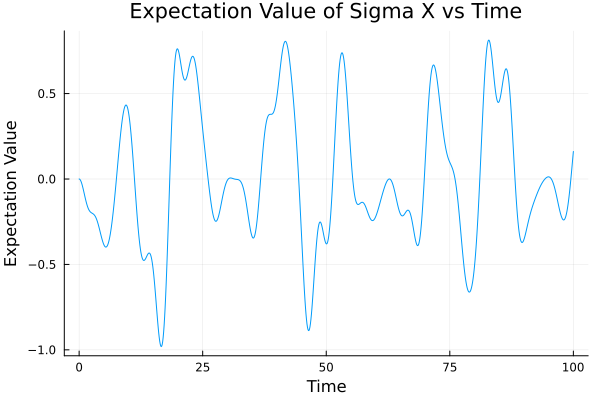

In [147]:
plot(T, exp_sig_x, xlabel="Time", ylabel="Expectation Value", title="Expectation Value of Sigma X vs Time", legend=false)

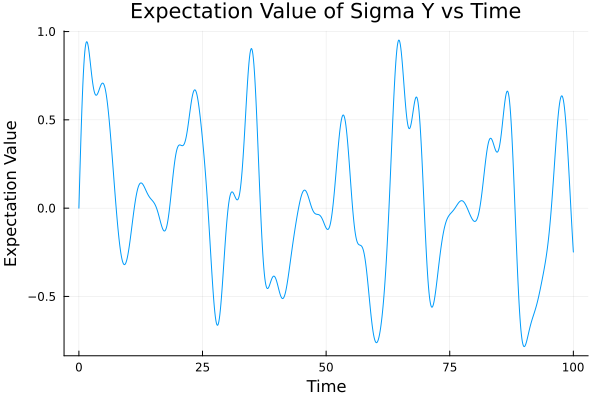

In [148]:
plot(T, exp_sig_y, xlabel="Time", ylabel="Expectation Value", title="Expectation Value of Sigma Y vs Time", legend=false)

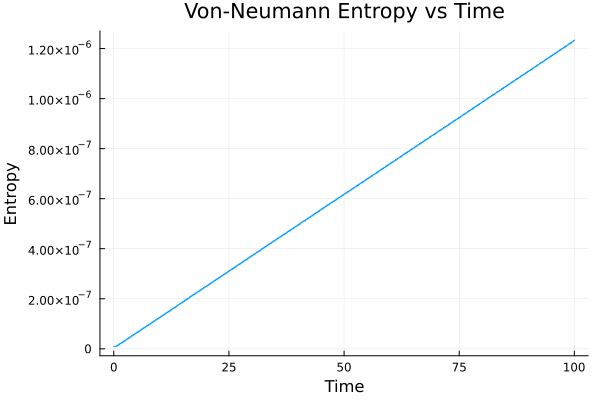

In [150]:
S_n = real.(entropy_vn.(Ψt))
plot(T, S_n, xlabel="Time", ylabel="Entropy", title="Von-Neumann Entropy vs Time", legend=false)